# Simulation of countermeasures

This notebook contains simulations of scalar randomization countermeasures acting under the five tests:
 - [The 3n test](#3n-test)
 - [The $n + \epsilon$ test](#Mask-recovery-(n+ϵ-test)) including mask recovery
 - [The $k = 10$ test](#k=10-test)
 - [The composite test](#Composite-test)
 - [The EPA test](#EPA-test)

In [8]:
import io
import math
import random
import itertools
import warnings

import cypari2
from cysignals.alarm import alarm, AlarmInterrupt

from matplotlib import pyplot as plt
from collections import Counter
from tqdm.auto import tqdm, trange

from pyecsca.misc.cfg import TemporaryConfig
from pyecsca.misc.utils import TaskExecutor
from pyecsca.ec.mod import mod, RandomModAction
from pyecsca.ec.point import Point
from pyecsca.ec.model import ShortWeierstrassModel
from pyecsca.ec.params import load_params_ectester, get_params
from pyecsca.ec.mult import LTRMultiplier, RTLMultiplier, ScalarMultiplicationAction
from pyecsca.ec.context import local, DefaultContext
from pyecsca.ec.countermeasures import GroupScalarRandomization, AdditiveSplitting, MultiplicativeSplitting, EuclideanSplitting, BrumleyTuveri

%matplotlib ipympl

Let's first initialize some useful objects. We will be working with projective coordinates and the `add-2007-bl` and `dbl-2007-bl` formulas, though any formulas would work. However, one obtains different results if working with complete formulas.

In [9]:
model = ShortWeierstrassModel()
coords = model.coordinates["projective"]

In [10]:
add = coords.formulas["add-2007-bl"]
dbl = coords.formulas["dbl-2007-bl"]
ltr = LTRMultiplier(add, dbl, complete=False)
rtl = RTLMultiplier(add, dbl, complete=False)
mult = ltr

In [11]:
gsr = GroupScalarRandomization(mult)
gsr160 = GroupScalarRandomization(mult, 160)
asplit = AdditiveSplitting(mult)
msplit = MultiplicativeSplitting(mult)
esplit = EuclideanSplitting(mult)
bt = BrumleyTuveri(mult)

## 3n test

In the 3n test the target is given domain parameters of order $3n$ but claimed order $n$. The target is then given a point of order $3n$ for scalar multiplication and the results are observed.

In [5]:
key3n = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006
params3n = load_params_ectester(io.BytesIO(b"0xc381bb0394f34b5ed061c9107b66974f4d0a8ec89b9fe73b98b6d1368c7d974d,0x5ca6c5ee0a10097af291a8f125303fb1a3e35e8100411902245d691e0e5cb497,0x385a5a8bb8af94721f6fd10b562606d9b9df931f7fd966e96859bb9bd7c05836,0x4616af1898b92cac0f902a9daee24bbae63571cead270467c6a7886ced421f5e,0x34e896bdb1337e0ae5960fa3389fb59c2c8d6c7dbfd9aac33a844f8f98e433ef,0x412b3e5686fbc3ca4575edb0292232702ae721a7d4a230cc170a5561aa70e00f,0x01"), "projective")
bits3n = params3n.full_order.bit_length()
point3n = Point(X=mod(0x4a48addb2e471767b7cd0f6f1d4c27fe46f4a828fc20f950bd1f72c939b36a84, params3n.curve.prime),
                Y=mod(0x13384d38c353f862832c0f067e46a3e510bb6803c20745dfb31929f4a18d890d, params3n.curve.prime),
                Z=mod(1, params3n.curve.prime), model=coords)

In [6]:
print(f"prime:\t0x{params3n.curve.prime:x}")
print(f"a:\t0x{params3n.curve.parameters['a']:x}")
print(f"b:\t0x{params3n.curve.parameters['b']:x}")
print(f"G:\t[0x{params3n.generator.X:x},\n\t 0x{params3n.generator.Y:x}]")
print(f"n:\t0x{params3n.order:x}")
print(f"3n:\t0x{3 * params3n.order:x}")
print(f"\nP:\t[0x{point3n.X:x},\n\t 0x{point3n.Y:x}]")

prime:	0xc381bb0394f34b5ed061c9107b66974f4d0a8ec89b9fe73b98b6d1368c7d974d
a:	0x5ca6c5ee0a10097af291a8f125303fb1a3e35e8100411902245d691e0e5cb497
b:	0x385a5a8bb8af94721f6fd10b562606d9b9df931f7fd966e96859bb9bd7c05836
G:	[0x4616af1898b92cac0f902a9daee24bbae63571cead270467c6a7886ced421f5e,
	 0x34e896bdb1337e0ae5960fa3389fb59c2c8d6c7dbfd9aac33a844f8f98e433ef]
n:	0x412b3e5686fbc3ca4575edb0292232702ae721a7d4a230cc170a5561aa70e00f
3n:	0xc381bb0394f34b5ed061c9107b66975080b564f77de69264451f0024ff52a02d

P:	[0x4a48addb2e471767b7cd0f6f1d4c27fe46f4a828fc20f950bd1f72c939b36a84,
	 0x13384d38c353f862832c0f067e46a3e510bb6803c20745dfb31929f4a18d890d]


In [7]:
def generate_scalars_mod3(rem, samples):
    scalars = []
    while True:
        scalar = random.randint(0, params3n.full_order)
        if scalar % 3 == rem:
            scalars.append(scalar)
        if len(scalars) == samples:
            break
    return scalars

def test_3n(countermeasure, scalars):
    ctr = Counter()
    for k in tqdm(scalars, leave=False):
        mult.init(params3n, point3n)
        kP = mult.multiply(k).to_affine()
        mult.init(params3n, point3n)
        knP = mult.multiply(k + params3n.full_order).to_affine()
        mult.init(params3n, point3n)
        k2nP = mult.multiply(k + 2 * params3n.full_order).to_affine()

        countermeasure.init(params3n, point3n)
        res = countermeasure.multiply(k)
        aff = res.to_affine()
        if aff.equals(kP):
            ctr["k"] += 1
        elif aff.equals(knP):
            ctr["k + 1n"] += 1
        elif aff.equals(k2nP):
            ctr["k + 2n"] += 1
        else:
            ctr[aff] += 1
    for name, count in sorted(ctr.items()):
        print(f"{name}:\t{count}")

def test_3n_fixed_scalar(countermeasure, samples):
    test_3n(countermeasure, [key3n for _ in range(samples)])

def test_3n_random_scalar(countermeasure, samples):
    test_3n(countermeasure, [random.randint(0, params3n.full_order) for _ in range(samples)])

def test_3n_random_scalar_projected(countermeasure, samples):
    print("k = 0 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(0, samples))
    print()
    print("k = 1 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(1, samples))
    print()
    print("k = 2 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(2, samples))

### Fixed scalar experiments

#### Group scalar randomization

In [8]:
test_3n_fixed_scalar(gsr, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	354
k + 1n:	318
k + 2n:	328


#### Additive splitting

In [9]:
test_3n_fixed_scalar(asplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	508
k + 1n:	492


#### Multiplicative splitting

In [10]:
test_3n_fixed_scalar(msplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	192
k + 1n:	575
k + 2n:	233


#### Euclidean splitting

In [11]:
test_3n_fixed_scalar(esplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	1000


#### Brumley and Tuveri bit-length fixing

In [12]:
test_3n_fixed_scalar(bt, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k + 2n:	1000


### Random scalar experiments

#### Group scalar randomization

In [13]:
test_3n_random_scalar(gsr, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	331
k + 1n:	339
k + 2n:	330


#### Additive splitting

In [14]:
test_3n_random_scalar(asplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	499
k + 1n:	501


#### Multiplicative splitting

In [15]:
test_3n_random_scalar(msplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	313
k + 1n:	352
k + 2n:	335


#### Euclidean splitting

In [16]:
test_3n_random_scalar(esplit, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k:	1000


#### Brumley and Tuveri bit-length fixing

In [17]:
test_3n_random_scalar(bt, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

k + 1n:	28
k + 2n:	972


### Random scalar experiments projected to scalar divisor classes mod 3

#### Group scalar randomization

In [18]:
test_3n_random_scalar_projected(gsr, 1000)

k = 0 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	312
k + 1n:	357
k + 2n:	331

k = 1 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	291
k + 1n:	358
k + 2n:	351

k = 2 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	342
k + 1n:	338
k + 2n:	320


#### Additive splitting

In [19]:
test_3n_random_scalar_projected(asplit, 1000)

k = 0 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	500
k + 1n:	500

k = 1 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	528
k + 1n:	472

k = 2 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	531
k + 1n:	469


#### Multiplicative splitting

In [20]:
test_3n_random_scalar_projected(msplit, 1000)

k = 0 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	571
k + 1n:	190
k + 2n:	239

k = 1 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	217
k + 1n:	232
k + 2n:	551

k = 2 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	209
k + 1n:	546
k + 2n:	245


#### Euclidean splitting

In [21]:
test_3n_random_scalar_projected(esplit, 1000)

k = 0 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	1000

k = 1 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	1000

k = 2 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k:	1000


#### Brumley and Tuveri bit-length fixing

In [22]:
test_3n_random_scalar_projected(bt, 1000)

k = 0 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k + 1n:	35
k + 2n:	965

k = 1 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k + 1n:	36
k + 2n:	964

k = 2 mod 3


  0%|          | 0/1000 [00:00<?, ?it/s]

k + 1n:	37
k + 2n:	963


## Mask recovery ($n + \epsilon$ test)
Using a composite order curve we can recover the size and the actual mask values (in a known key scenario) in both GSR and multiplicative splitting. However, real-world targets do not like composite order curves and may either check the order or otherwise fail to compute on such curves. Thus, we lie to them and set the order to the next-prime of the true order, in this case $n + 92$.

In [23]:
pari = cypari2.Pari(256_000_000, 2_000_000_000)

In [24]:
real_n = 0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df50775
#      = 2898786277 * 2916913393 * 3067509271 * 3248233993 * 3894099889 * 4099407227 * 4101666977 * 13936975277
real_n_facts = pari.factor(real_n)
params92pn = load_params_ectester(io.BytesIO(b"0xa9fa3419aca88bade2cba14e317816c79d52481d463dc9bcb12c37f45aa3b4e1,0x2ea3bfe6659f8e035735349b91fbfa2baf0cf8e640315f0fe03c1136813dec99,0x2b07c518e04b02158651e3dbbef7720015dd496bf15af02f8439f8e1503b8370,0x90fb04b1af19e8e20396ac052f260a9fb5f736b97e3cd4af08fe81a1e75dac6d,0x2302bcf700d3d5899f04d0c7441f5017c9758bfafd6ce15dbe36fb4eea76baec,0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df507d1,0x01"), "projective")
e = pari.ellinit([int(params92pn.curve.parameters["a"]), int(params92pn.curve.parameters["b"])], int(params92pn.curve.prime))
e[15][0] = real_n

In [25]:
print(f"prime:\t0x{params92pn.curve.prime:x}")
print(f"a:\t0x{params92pn.curve.parameters['a']:x}")
print(f"b:\t0x{params92pn.curve.parameters['b']:x}")
print(f"G:\t[0x{params92pn.generator.X:x},\n\t 0x{params92pn.generator.Y:x}]")
print(f"n+92:\t0x{params92pn.order:x} (fake order, given to the target, prime)")
print(f"n:\t0x{real_n:x} (real order, composite)")

prime:	0xa9fa3419aca88bade2cba14e317816c79d52481d463dc9bcb12c37f45aa3b4e1
a:	0x2ea3bfe6659f8e035735349b91fbfa2baf0cf8e640315f0fe03c1136813dec99
b:	0x2b07c518e04b02158651e3dbbef7720015dd496bf15af02f8439f8e1503b8370
G:	[0x90fb04b1af19e8e20396ac052f260a9fb5f736b97e3cd4af08fe81a1e75dac6d,
	 0x2302bcf700d3d5899f04d0c7441f5017c9758bfafd6ce15dbe36fb4eea76baec]
n+92:	0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df507d1 (fake order, given to the target, prime)
n:	0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df50775 (real order, composite)


### Group scalar randomization
In GSR getting the mask out this way is quite simple. The target believes it is operating on a curve of order $n+92$ so it will use that value multiplied with the mask to randomize the scalar. Thus as a result we get:
$$ P = [k + r(n + 92)]G $$

However, the curve is truly of order $n$, thus arithmetic on its group will make this equal to: 
$$ P = [k + r 92]G $$

Since this is a composite order curve, we can solve the dlog and obtain $k + r 92$ and since we assume we know $k$ we can easily compute both the mask size and mask value $r$.

In [26]:
key = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006  # any key works ofc
gsr.init(params92pn, params92pn.generator)
res = gsr.multiply(key)

In [27]:
affine_gen = params92pn.generator.to_affine()
affine_res = res.to_affine()

In [28]:
dlog = pari.elllog(e,
                   [int(affine_res.x), int(affine_res.y)],
                   [int(affine_gen.x), int(affine_gen.y)],
                   real_n)

In [29]:
mask = int((dlog - key) / 92)
mask_len = mask.bit_length()
print(mask)
print(mask_len)

2799400670
32


### Multiplicative splitting
In multiplicative splitting the situation is a bit more complicated. Doing the same computation, where the target thinks the curve order is $n+92$ leads to:
$$ P = [k r^{-1}\pmod{n+92}][r \mod n]G $$

Since the curve is composite order we can easily compute the dlog $d$ of P to G, we get:
$$ d = (k r^{-1})\pmod{n+92}\: r  = k + t (n + 92) $$

However, the dlog is computed $\mod n$ so we really get: $ d = k + t 92$. We extract the $t$ out of this.
Note that $t$ will have roughly the same size as the mask $r$, since at the left side we have $(k r^{-1}) {\mod (n+92)}$
of size $n$ and $r$ of size of the mask and on the right size we have $t n$ that dominates.
Thus at this point we have recovered the mask size.
However, $t$ is always smaller than $r$, sometimes also in bitsize.

Now that we have $s$ we can go back to the original equation and get:
$$ (k r^{-1})\pmod{n+92}\: r = k + t (n + 92) $$

We can then factor this value, lets call it $full$, and look for divisors that are larger than $t$ but smaller than the mask length
that we recovered before. There may be multiple candidates here and we don't know how to distinguish between
them. It holds for all of the candidates $c$ that the rest of the value $full$ is equal to the inverse of $c \mod (n+92)$.
However, sometimes there is only one candidate, which is equal to the true mask value $r$.

In [30]:
def divisors(primes, powers):
    for comb in itertools.product(*[range(power+1) for power in powers]):
        value = 1
        for prime, power in zip(primes, comb):
            value *= prime**power
        yield value

def pari_factor(number, flag=1+8, duration=5*60):
    # Use the 1 + 8 option to factorint to skip some costly factorization methods, we don't need the huge factors.
    # This means that some factors may remain, which in turn means that sometimes we may not find the true mask.
    pari = cypari2.Pari(256_000_000, 2_000_000_000)
    with warnings.catch_warnings(category=RuntimeWarning):
        warnings.simplefilter("ignore")
        try:
            alarm(duration)
            factors = pari.factorint(number, flag)
        except AlarmInterrupt:
            return None
    primes = list(map(int, factors[0]))
    powers = list(map(int, factors[1]))
    return primes, powers

def pari_dlog(params, P, G, real_n, facts_str):
    pari = cypari2.Pari(256_000_000, 2_000_000_000)
    e = pari.ellinit([int(params.curve.parameters["a"]), int(params.curve.parameters["b"])], int(params.curve.prime))
    e[15][0] = real_n
    facts = pari(facts_str)
    dlog = pari.elllog(e, P, G, facts)
    return int(dlog)

In [31]:
key = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006  # any key works
msplit = MultiplicativeSplitting(mult, rand_bits=32)  # change the mask size here to your liking
tries = 1000
num_workers = 30

blens = [None for _ in range(tries)]
dlogs = [None for _ in range(tries)]
ts = [None for _ in range(tries)]

results = [None for _ in range(tries)]
rs = [None for _ in range(tries)]

with TaskExecutor(max_workers=num_workers) as pool:
    for i in trange(tries, desc="Collecting scalarmults"):
        msplit.init(params92pn, params92pn.generator)
        with local(DefaultContext()) as ctx:
            res = msplit.multiply(key)
    
        affine_res = res.to_affine()
        affine_gen = params92pn.generator.to_affine()
        results[i] = affine_res
        
        rval = []
        ctx.actions[0].walk(lambda action: rval.append(int(action.result)) if isinstance(action, RandomModAction) else None)
        rs[i] = rval[0]
        
        pool.submit_task(i,
                         pari_dlog,
                         params92pn,
                         [int(affine_res.x), int(affine_res.y)],
                         [int(affine_gen.x), int(affine_gen.y)],
                         real_n,
                         repr(real_n_facts))
    
    for i, future in tqdm(pool.as_completed(), desc="Computing dlogs", total=len(pool.tasks)):
        dlog = future.result()
        val = dlog - key
        if val % 92 != 0:
            print(f"Bad val! {i}")
        t = val // 92
        ts[i] = t
        dlogs[i] = dlog
        blens[i] = t.bit_length()

mask_len = max(blens)
print(mask_len, mask_len == msplit.rand_bits)

Computing dlogs:   0%|          | 0/1000 [00:00<?, ?it/s]

32 True


In [32]:
with TaskExecutor(max_workers=num_workers) as pool:
    fulls = []
    for t in ts:
        full = t * (real_n + 92) + key
        fulls.append(full)
        pool.submit_task(t,
                         pari_factor,
                         full, flag=0)
    facts = [None for _ in ts]
    for t, future in tqdm(pool.as_completed(), desc="Factoring", total=len(ts)):
        result = future.result()
        if result is None:
            print("Timed out.")
        facts[ts.index(t)] = result

Factoring:   0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
candidate_amounts = []
i = 0
for dlog, t, blen, r, fact, full, result in zip(dlogs, ts, blens, rs, facts, fulls, results):
    if fact is None:
        continue
    
    (primes, powers) = fact
    complete = True
    for prime in primes:
        if not pari.isprime(prime):
            complete = False
            break

    i += 1
    candidates = set()
    for divisor in divisors(primes, powers):
        if divisor.bit_length() <= mask_len and divisor >= t:
            candidates.add(divisor)
    candidate_amounts.append(len(candidates))
    if len(candidates) == 1:
        candidate = candidates.pop()
        print("Only one candidate, we got the mask:", candidate, candidate == r, "incomplete factoring this may not be the r" if not complete else "")
print(f"Total recovered masks: {len(list(filter(lambda a: a == 1, candidate_amounts)))} out of {i}")

Only one candidate, we got the mask: 4210661147 True 
Only one candidate, we got the mask: 1369579171 True 
Only one candidate, we got the mask: 2876457637 True 
Only one candidate, we got the mask: 2280856345 True 
Only one candidate, we got the mask: 827717755 True 
Only one candidate, we got the mask: 4072523937 True 
Only one candidate, we got the mask: 758839701 True 
Only one candidate, we got the mask: 469568509 True 
Only one candidate, we got the mask: 3990260303 True 
Only one candidate, we got the mask: 1505311001 True 
Only one candidate, we got the mask: 2299553601 True 
Only one candidate, we got the mask: 697503202 True 
Only one candidate, we got the mask: 4252750043 True 
Only one candidate, we got the mask: 2628411277 True 
Only one candidate, we got the mask: 4059149439 True 
Only one candidate, we got the mask: 1361652212 True 
Only one candidate, we got the mask: 3472878829 True 
Only one candidate, we got the mask: 3240581563 True 
Only one candidate, we got the m

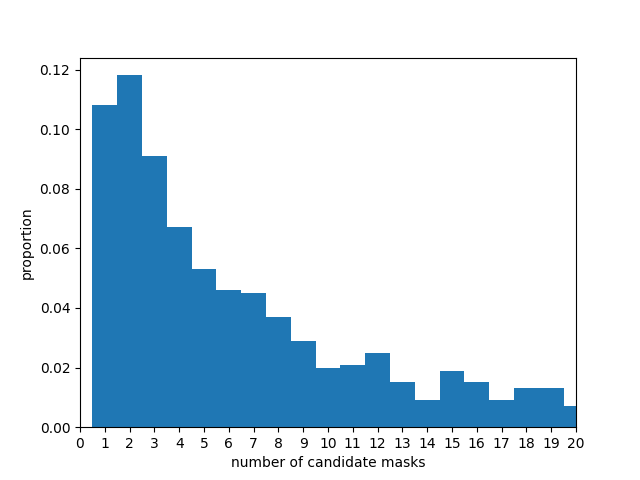

In [34]:
max_amount = max(candidate_amounts)
fig = plt.subplots()
plt.hist(candidate_amounts, range=(1, max_amount), align="left", density=True, bins=range(1, max_amount))#, bins=list(range(20)) + list(range(20, 100, 5)) + list(range(100, max(candidate_amounts), 10)))
plt.xlabel("number of candidate masks")
plt.ylabel("proportion")
plt.xticks(range(max_amount))
plt.xlim(0, 20);
plt.show()

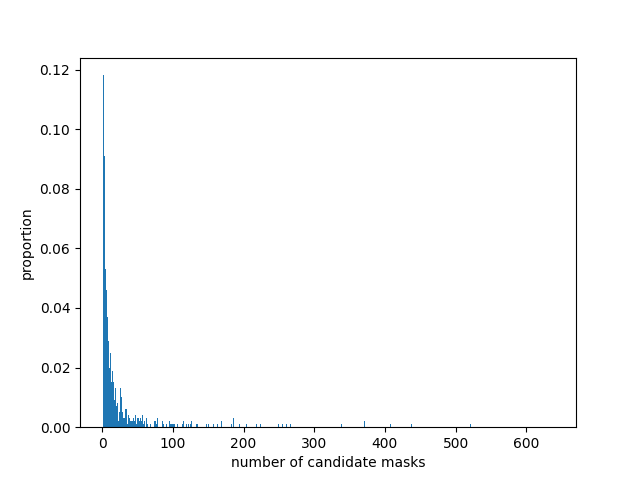

In [35]:
max_amount = max(candidate_amounts)
fig = plt.subplots()
plt.hist(candidate_amounts, range=(1, max_amount), align="left", density=True, bins=range(1, max_amount))#, bins=list(range(20)) + list(range(20, 100, 5)) + list(range(100, max(candidate_amounts), 10)))
plt.xlabel("number of candidate masks")
plt.ylabel("proportion")
plt.show()

## $k = 10$ test

In [36]:
paramsk10 = get_params("secg", "secp256r1", "projective")

In [37]:
def test_k10(countermeasure, samples, k_range = None, zero_fails = True, plot=True):
    G = paramsk10.generator
    Gaff = G.to_affine()
    if k_range is None:
        ks = list(range(2, 21))
    else:
        ks = list(k_range)
    fails = []
    for k in ks:
        correct = 0
        failed = 0
        expected = paramsk10.curve.affine_multiply(Gaff, k).to_model(paramsk10.curve.coordinate_model, paramsk10.curve)
        for _ in range(samples):
            with local(DefaultContext()) as ctx:
                countermeasure.init(paramsk10, paramsk10.generator)
                res = countermeasure.multiply(k)
            smults = set()
            ctx.actions[0].walk(lambda action: smults.add(action.scalar) if isinstance(action, ScalarMultiplicationAction) else None)
            if 0 in smults and zero_fails:
                failed += 1
                continue
            try:
                if res.equals_scaled(expected):
                    correct += 1
                else:
                    failed += 1
            except:
                failed += 1
        print(f"k = {k}: failed in {failed} out of {samples}.")
        fails.append(failed / samples)
    if plot:
        fig, ax = plt.subplots()
        xs = list(range(len(ks)))
        ax.plot(xs, fails, label="Error rate")
        if any(k > 100 for k in ks):
            ax.set_xticks(xs, (f"2^{int(math.log2(k))}" for k in ks))
        else:
            ax.set_xticks(xs, ks)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel("k")
        ax.set_ylabel("Error rate")
        ax.legend()
        plt.show()
    return fails

### Group scalar randomization

In GSR, the LTR simple double-and-add errors quite a lot for small scalars.

k = 2: failed in 25 out of 100.
k = 3: failed in 21 out of 100.
k = 4: failed in 11 out of 100.
k = 5: failed in 11 out of 100.
k = 6: failed in 14 out of 100.
k = 7: failed in 10 out of 100.
k = 8: failed in 9 out of 100.
k = 9: failed in 9 out of 100.
k = 10: failed in 3 out of 100.
k = 11: failed in 6 out of 100.
k = 12: failed in 4 out of 100.
k = 13: failed in 4 out of 100.
k = 14: failed in 4 out of 100.
k = 15: failed in 4 out of 100.
k = 16: failed in 1 out of 100.
k = 17: failed in 5 out of 100.
k = 18: failed in 6 out of 100.
k = 19: failed in 6 out of 100.
k = 20: failed in 1 out of 100.


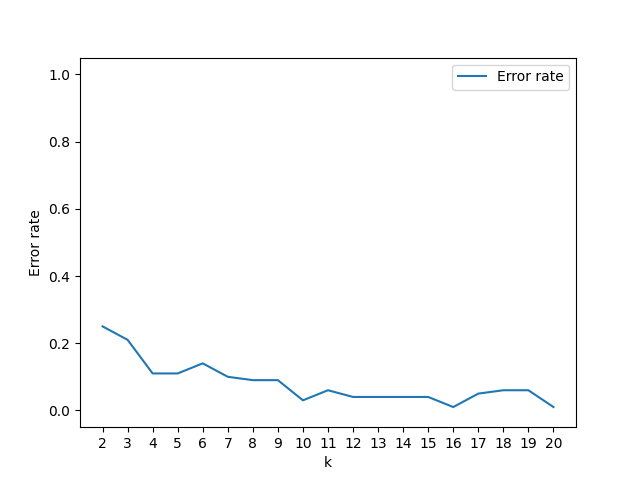

In [38]:
test_k10(gsr, 100);

However, the RTL double-and-add does not error at all.

k = 2: failed in 0 out of 100.
k = 3: failed in 0 out of 100.
k = 4: failed in 0 out of 100.
k = 5: failed in 0 out of 100.
k = 6: failed in 0 out of 100.
k = 7: failed in 0 out of 100.
k = 8: failed in 0 out of 100.
k = 9: failed in 0 out of 100.
k = 10: failed in 0 out of 100.
k = 11: failed in 0 out of 100.
k = 12: failed in 0 out of 100.
k = 13: failed in 0 out of 100.
k = 14: failed in 0 out of 100.
k = 15: failed in 0 out of 100.
k = 16: failed in 0 out of 100.
k = 17: failed in 0 out of 100.
k = 18: failed in 0 out of 100.
k = 19: failed in 0 out of 100.
k = 20: failed in 0 out of 100.


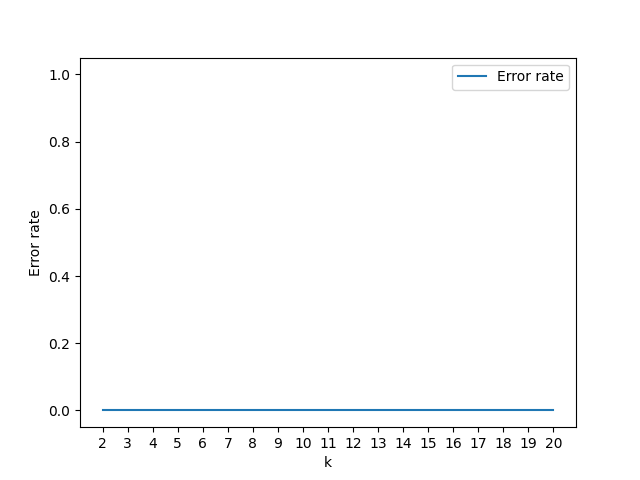

In [39]:
test_k10(GroupScalarRandomization(rtl), 100);

### Multiplicative splitting
Multiplicative splitting has no reason to error out.

k = 2: failed in 0 out of 100.
k = 3: failed in 0 out of 100.
k = 4: failed in 0 out of 100.
k = 5: failed in 0 out of 100.
k = 6: failed in 0 out of 100.
k = 7: failed in 0 out of 100.
k = 8: failed in 0 out of 100.
k = 9: failed in 0 out of 100.
k = 10: failed in 0 out of 100.
k = 11: failed in 0 out of 100.
k = 12: failed in 0 out of 100.
k = 13: failed in 0 out of 100.
k = 14: failed in 0 out of 100.
k = 15: failed in 0 out of 100.
k = 16: failed in 0 out of 100.
k = 17: failed in 0 out of 100.
k = 18: failed in 0 out of 100.
k = 19: failed in 0 out of 100.
k = 20: failed in 0 out of 100.


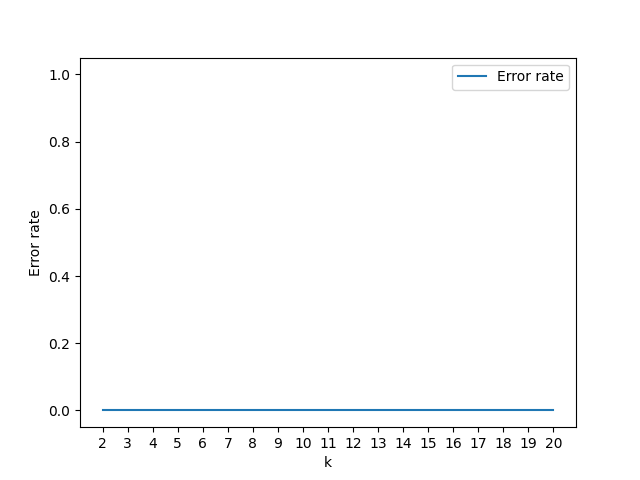

In [40]:
test_k10(msplit, 100);

### Euclidean splitting
In Euclidean splitting, it matters whether we consider the computation $[0]G$ to error or not, i.e., whether the implementation is setup to handle a zero scalar gracefully. If it is not, we get 100% of errors for small scalars.

k = 2: failed in 100 out of 100.
k = 3: failed in 100 out of 100.
k = 4: failed in 100 out of 100.
k = 5: failed in 100 out of 100.
k = 6: failed in 100 out of 100.
k = 7: failed in 100 out of 100.
k = 8: failed in 100 out of 100.
k = 9: failed in 100 out of 100.
k = 10: failed in 100 out of 100.
k = 11: failed in 100 out of 100.
k = 12: failed in 100 out of 100.
k = 13: failed in 100 out of 100.
k = 14: failed in 100 out of 100.
k = 15: failed in 100 out of 100.
k = 16: failed in 100 out of 100.
k = 17: failed in 100 out of 100.
k = 18: failed in 100 out of 100.
k = 19: failed in 100 out of 100.
k = 20: failed in 100 out of 100.


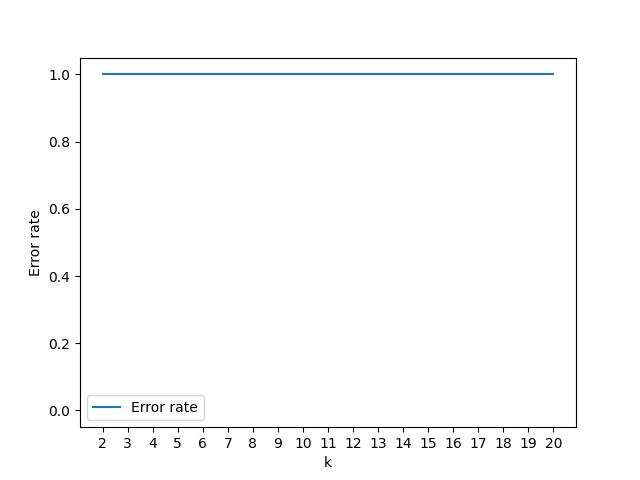

In [41]:
test_k10(esplit, 100);

However, if it **is** setup to handle a zero scalar, we get no errors on small scalars.

k = 2: failed in 0 out of 100.
k = 3: failed in 0 out of 100.
k = 4: failed in 0 out of 100.
k = 5: failed in 0 out of 100.
k = 6: failed in 0 out of 100.
k = 7: failed in 0 out of 100.
k = 8: failed in 0 out of 100.
k = 9: failed in 0 out of 100.
k = 10: failed in 0 out of 100.
k = 11: failed in 0 out of 100.
k = 12: failed in 0 out of 100.
k = 13: failed in 0 out of 100.
k = 14: failed in 0 out of 100.
k = 15: failed in 0 out of 100.
k = 16: failed in 0 out of 100.
k = 17: failed in 0 out of 100.
k = 18: failed in 0 out of 100.
k = 19: failed in 0 out of 100.
k = 20: failed in 0 out of 100.


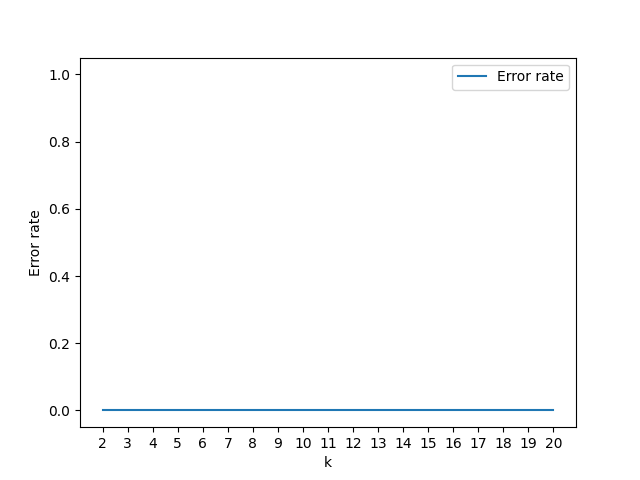

In [42]:
test_k10(esplit, 100, zero_fails=False);

When we look back at the case where a zero scalar is mishandled, we see the errors drop-off when we reach the size of tha random mask.

k = 1329227995784915872903807060280344576: failed in 100 out of 100.
k = 2658455991569831745807614120560689152: failed in 99 out of 100.
k = 5316911983139663491615228241121378304: failed in 100 out of 100.
k = 10633823966279326983230456482242756608: failed in 99 out of 100.
k = 21267647932558653966460912964485513216: failed in 95 out of 100.
k = 42535295865117307932921825928971026432: failed in 84 out of 100.
k = 85070591730234615865843651857942052864: failed in 76 out of 100.
k = 170141183460469231731687303715884105728: failed in 55 out of 100.
k = 340282366920938463463374607431768211456: failed in 0 out of 100.
k = 680564733841876926926749214863536422912: failed in 0 out of 100.
k = 1361129467683753853853498429727072845824: failed in 0 out of 100.
k = 2722258935367507707706996859454145691648: failed in 0 out of 100.
k = 5444517870735015415413993718908291383296: failed in 0 out of 100.
k = 10889035741470030830827987437816582766592: failed in 0 out of 100.


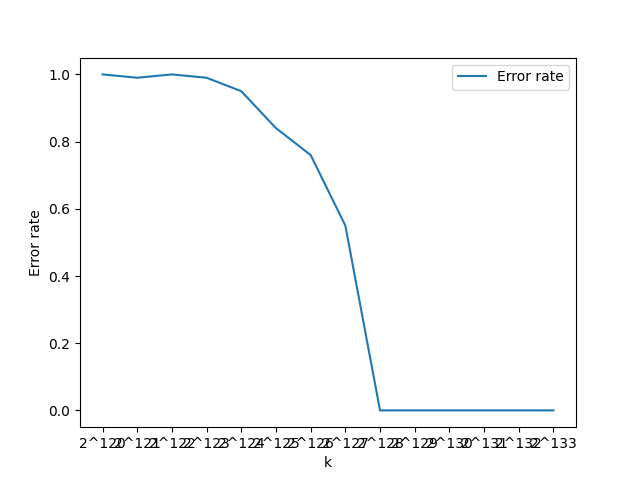

In [43]:
test_k10(esplit, 100, (2**i for i in range(120, 134)));

In the "no-error-on-zero" case, we see no errors even up to and past the random mask size.

k = 4: failed in 0 out of 100.
k = 8: failed in 0 out of 100.
k = 16: failed in 0 out of 100.
k = 32: failed in 0 out of 100.
k = 64: failed in 0 out of 100.
k = 128: failed in 0 out of 100.
k = 256: failed in 0 out of 100.
k = 512: failed in 0 out of 100.
k = 1024: failed in 0 out of 100.
k = 2048: failed in 0 out of 100.
k = 4096: failed in 0 out of 100.
k = 8192: failed in 0 out of 100.
k = 16384: failed in 0 out of 100.
k = 32768: failed in 0 out of 100.
k = 65536: failed in 0 out of 100.
k = 131072: failed in 0 out of 100.
k = 262144: failed in 0 out of 100.
k = 524288: failed in 0 out of 100.
k = 1048576: failed in 0 out of 100.
k = 2097152: failed in 0 out of 100.
k = 4194304: failed in 0 out of 100.
k = 8388608: failed in 0 out of 100.
k = 16777216: failed in 0 out of 100.
k = 33554432: failed in 0 out of 100.
k = 67108864: failed in 0 out of 100.
k = 134217728: failed in 0 out of 100.
k = 268435456: failed in 0 out of 100.
k = 536870912: failed in 0 out of 100.
k = 1073741824:

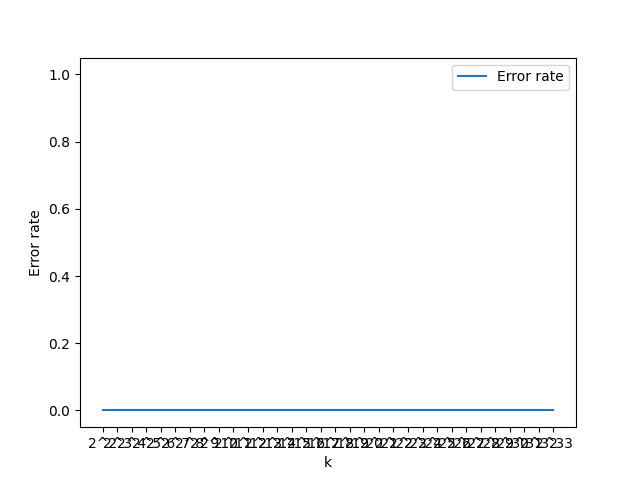

In [44]:
test_k10(esplit, 100, (2**i for i in range(2, 34)), zero_fails=False);

### Additive splitting
Additive splitting has no reason to error out.

k = 2: failed in 0 out of 100.
k = 3: failed in 0 out of 100.
k = 4: failed in 0 out of 100.
k = 5: failed in 0 out of 100.
k = 6: failed in 0 out of 100.
k = 7: failed in 0 out of 100.
k = 8: failed in 0 out of 100.
k = 9: failed in 0 out of 100.
k = 10: failed in 0 out of 100.
k = 11: failed in 0 out of 100.
k = 12: failed in 0 out of 100.
k = 13: failed in 0 out of 100.
k = 14: failed in 0 out of 100.
k = 15: failed in 0 out of 100.
k = 16: failed in 0 out of 100.
k = 17: failed in 0 out of 100.
k = 18: failed in 0 out of 100.
k = 19: failed in 0 out of 100.
k = 20: failed in 0 out of 100.


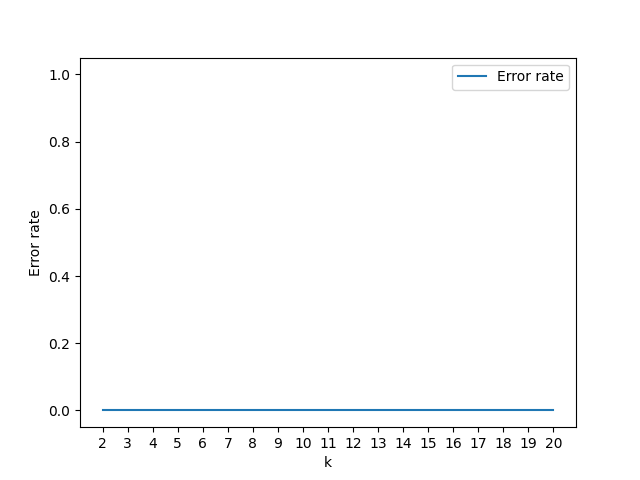

In [45]:
test_k10(asplit, 100);

## Composite test

The composite test works by observing the implementation operating on a composite order curve. The order of the curve is correctly presented to the implementation, so this test is not applicable to targets that check primality of the curve order.

This test is able to detect the presence of multiplicative splitting, due to errors arising from trying to invert the random mask modulo a composite order. Based on the inversion algorithm used, different behaviors may be present. Importantly, the other countermeasures do not error on composite order curves.

In [93]:
composite = load_params_ectester(io.BytesIO(b"0xc7a3ef9fa4ea63b537eedefc6bd52c3f35dc45be933d44270a1536c2ff9b6543,0x395f3675858362cbe7ac0d3e85708750aa42428368ae6ab1fda0d2a56255039b,0x61ca87695d4f6147b35975326eeee1a77f93226487315cd2419b4a1fe23f32d1,0x56e9a905d29f0f512cf709522bdd43a862d4e32c46268eec2f4c3fd9a70cb9d6,0xaf77a4ef604d33e3cf6c2ecaaa2913a5c51660e40365832ab98488950f3c348e,0xc7a3ef9fa4ea63b537eedefc6bd52c40f5e8e3bfe0f6dd05ac513edbcaa3cc47,0x01"), "projective")

The order is 11-times a big prime.

In [94]:
print(f"prime:\t0x{composite.curve.prime:x}")
print(f"a:\t0x{composite.curve.parameters['a']:x}")
print(f"b:\t0x{composite.curve.parameters['b']:x}")
print(f"G:\t[0x{composite.generator.X:x},\n\t 0x{composite.generator.Y:x}]")
print(f"n:\t0x{composite.order:x}")

prime:	0xc7a3ef9fa4ea63b537eedefc6bd52c3f35dc45be933d44270a1536c2ff9b6543
a:	0x395f3675858362cbe7ac0d3e85708750aa42428368ae6ab1fda0d2a56255039b
b:	0x61ca87695d4f6147b35975326eeee1a77f93226487315cd2419b4a1fe23f32d1
G:	[0x56e9a905d29f0f512cf709522bdd43a862d4e32c46268eec2f4c3fd9a70cb9d6,
	 0xaf77a4ef604d33e3cf6c2ecaaa2913a5c51660e40365832ab98488950f3c348e]
n:	0xc7a3ef9fa4ea63b537eedefc6bd52c40f5e8e3bfe0f6dd05ac513edbcaa3cc47


The test consists of repeatedly performing the operation (ECDH, keygen, ECDSA) and observing whether the implementation returns an error and checking the validity of the result if it returns a result.

In [95]:
def test_composite(countermeasure, samples):
    G = composite.generator
    Gaff = G.to_affine()
    correct = 0
    errors = 0
    wrong = 0
    for _ in range(samples):
        k = random.randrange(0, composite.full_order)
        countermeasure.init(composite, G)
        try:
            res = countermeasure.multiply(k)
            res_aff = composite.curve.affine_multiply(Gaff, k)
        
            if res.equals_scaled(res_aff.to_model(composite.curve.coordinate_model, composite.curve)):
                correct += 1
            else:
                wrong += 1
        except Exception as e:
            errors += 1
    print(f"{errors} errors, {wrong} wrong results")

### No countermeasures
Scalar multipliers without countermeasures have no issues computing over composite order curves.

In [74]:
test_composite(ltr, 100)

0 errors, 0 wrong results


In [75]:
test_composite(rtl, 100)

0 errors, 0 wrong results


### Group scalar randomization
GSR has no issues computing over composite order curves.

In [113]:
test_composite(gsr, 100)

0 errors, 0 wrong results


### Multiplicative splitting
When multiplicative splitting is used, the implementation may detect the element as not invertible and raise an error, as can be seen below when the extended euclid algorithm is used.

In [114]:
test_composite(msplit, 100)

Element not invertible.
Element not invertible.
Element not invertible.
Element not invertible.
Element not invertible.
Element not invertible.
6 errors, 0 wrong results


If we keep using the extended euclid algorithm but instead make the implementation ignore the errors and return the results, we get wrong results for masks that were not invertible.

In [115]:
with TemporaryConfig() as cfg:
    cfg.ec.no_inverse_action = "ignore"
    test_composite(msplit, 100)

0 errors, 11 wrong results


This also shows that all of the `Mod` implementations in pyecsca use extended euclid algorithm for the inversion.

In [116]:
with TemporaryConfig() as cfg:
    cfg.ec.no_inverse_action = "ignore"
    cfg.ec.mod_implementation = "python"
    test_composite(msplit, 100)

0 errors, 9 wrong results


In [117]:
with TemporaryConfig() as cfg:
    cfg.ec.no_inverse_action = "ignore"
    cfg.ec.mod_implementation = "gmp"
    test_composite(msplit, 100)

0 errors, 11 wrong results


In [118]:
with TemporaryConfig() as cfg:
    cfg.ec.no_inverse_action = "ignore"
    cfg.ec.mod_implementation = "flint"
    test_composite(msplit, 100)

0 errors, 11 wrong results


If we switch to inversion via Fermat's little theorem, we see that we always get wrong results.

In [119]:
def inverse(self) -> "RawMod":
    if self.x == 0:
        raise_non_invertible()
    res = self ** (self.n - 2)
    return RawMod(res.x, res.n)

with TemporaryConfig() as cfg:
    old_inverse = RawMod.inverse
    cfg.ec.mod_implementation = "python"
    cfg.ec.no_inverse_action = "ignore"
    RawMod.inverse = inverse
    test_composite(msplit, 100)
    RawMod.inverse = old_inverse

0 errors, 100 wrong results


### Additive splitting
Additive splitting has no issues computing over composite order curves.

In [78]:
test_composite(asplit, 100)

0 errors, 0 wrong results


### Euclidean splitting
Euclidean splitting has no issues computing over composite order curves.

In [79]:
test_composite(esplit, 100)

0 errors, 0 wrong results


### Brumley and Tuveri bit-length fixing
Brumley and Tuveri has no issues computing over composite order curves.

In [96]:
test_composite(bt, 100)

0 errors, 0 wrong results


## EPA test

The EPA test introduces the neutral (infinity) point to the scalar multiplication and observes whether the computation outputs an error (and how often). During a scalar multiplication $kP$, several multiples of the input point are gradually computed $k_1P,k_2P,\dots,k_rP=kP$. If any of the scalars $k_i$ is a multiple of the order of $P$, then the neutral point $k_iP=\infty$ appears and is used for futher computations which might lead to an error. The probability that this happens is mainly given by the size of the scalar $k$ and the order of the point $P$. The simulation below uses a point of order 373.

We can present the implementation the full order $373n$ (`params373full`) or we can hide the divisor and claim only $n$ (`params373hidden`).

In [74]:
params373hidden = load_params_ectester(io.BytesIO(b"0xeaabdf71acab107ab3ca581802a436a8b3a16b0ab2835994240b57d76d4ced13,0x6c66649a7c6a6c5f5c93d3bf27409b2b84cfcd2365fc902f061c2306046a7d2b,0x01d4b68f60ee4794fb2a364c6ab66ecefa0801fd8bd2266a29f7e756d3b9ec0a,0xaef417d0cbb8c113f92a9430e675c127690fab2bd3dc723b468e0309ca7de069,0x92b8fed2813c5820ef5ebfc9b1c26ccff580814d75bea54eab1426913f445dc4,0xa10fb2bff2bb695645dc8c133967c82d8a23c2ca1710a880c8d6b7dbd77565,0x1"), "projective")
params373full = load_params_ectester(io.BytesIO(b"0xeaabdf71acab107ab3ca581802a436a8b3a16b0ab2835994240b57d76d4ced13,0x6c66649a7c6a6c5f5c93d3bf27409b2b84cfcd2365fc902f061c2306046a7d2b,0x01d4b68f60ee4794fb2a364c6ab66ecefa0801fd8bd2266a29f7e756d3b9ec0a,0xb6d416d083c38c7d1345e050a880ab34dd62d2d1f54412296d2e434bf68df5e5,0xb3bd58bb4460da59cd6915160158062efd150bd7914d27631e70f03e0ec71a21,0xeaabdf71acab107ab3ca581802a436aa5a461ad0739b4583a4a0d9e350ee0c29,0x1"), "projective")
point373 = Point(X=mod(0x9b594237f596a9735053560e16df025b16eb566eacfb28ce24594782bc3e437f, params373.curve.prime),
                Y=mod(0xd8e171dcd78b13eaa05e6a12e66859c0ea37e133ac299544faa9f940c96f33c3, params373.curve.prime),
                Z=mod(1, params373.curve.prime), model=coords)
key = 0x5e22f7335e91e9ce65fe506178f34125f9f748ce6711888037c965f42a9a37
key_error = 0x7d767257fdc6eba6c1f7ba0812c8c7a7ae77934bd19d36c54b4faf31622bc9

In [75]:
def test_epa(countermeasure, tries, params=params373full, key=key):
    outputs = set()
    errors = 0
    correct = 0
    try:
        expected = params.curve.affine_multiply(point373.to_affine(), key)
    except Exception:
        expected = params.curve.neutral
    for _ in range(tries):
        countermeasure.init(params, point373)
        try:
            res = countermeasure.multiply(key)
            aff = res.to_affine()
            outputs.add(aff)
            if aff == expected:
                correct += 1
        except Exception:
            errors += 1
    print(f"{len(outputs)} unique outputs, {correct} correct, {errors} errors")
    if len(outputs) == 1:
        print(outputs)

### No countermeasures

When no countermeasures are applied, the scalar multiplication is deterministic. We either always get an error or never, depending on the scalar.

In [76]:
test_epa(mult, 100, key=key_error)

0 unique outputs, 0 correct, 100 errors


In [77]:
test_epa(mult, 100, key=key)

1 unique outputs, 100 correct, 0 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


### Group scalar randomization

With GSR, the sequence of scalars $k_i$ is no longer deterministic. The scalar multiplication sometimes outputs an error.

In [66]:
test_epa(gsr, 100, params373full)

1 unique outputs, 74 correct, 26 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


The size of the randomized scalar $k+rn$ is approximately $\log(nr)$. If we increase the size of the mask $r$ (from 32 to 160), the number of the scalars $k_i$ increases and the number of errors is then higher too.

In [71]:
test_epa(gsr160, 100, params373full)

1 unique outputs, 52 correct, 48 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


If the order used for the randomization is not a multiple of the input point, we also see incorrect results.

In [68]:
test_epa(gsr, 100, params373hidden)

61 unique outputs, 1 correct, 35 errors


### Multiplicative splitting

Multiplicative splitting computes two scalar multiplications with scalars of sizes $\log(r)$ and $\log(n)$. The sum of these is the same as in GSR and so the probability of an error is roughly the same.

In [72]:
test_epa(msplit, 100, params373full)

1 unique outputs, 63 correct, 37 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


In [73]:
test_epa(msplit, 100, params373hidden)

62 unique outputs, 1 correct, 32 errors


### Additive splitting

Since the additive splitting performs two scalar multiplications with scalars of size $\log(n)$, the probability of an error increases when compared to GSR or multiplicative splitting.

In [44]:
test_epa(asplit, 100, params373full)

1 unique outputs, 47 correct, 53 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


The additive splitting might reduce one of the scalars $k-r$ modulo $n$. If the order $n$ is not correct, it produces incorrect results.

In [63]:
test_epa(asplit, 100, params373hidden)

2 unique outputs, 34 correct, 46 errors


### Euclidean splitting

Euclidean splitting computes three scalar multiplication, but with scalars of half the size than the original scalar $k$. The number of errors is slightly higher than GSR or multiplicative splitting.

In [48]:
test_epa(esplit, 100, params373full)

1 unique outputs, 58 correct, 42 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


In [64]:
test_epa(esplit, 100, params373hidden)

1 unique outputs, 58 correct, 42 errors
{Point([x=50582717080162824157923262995758700615600207445800422082261146290031270523338, y=59054557706692485786050046234492855554939576857752133711491107905567203734259] in shortw/affine)}


### Brumley and Tuveri bit-length fixing

This countermeasure is not a scalar randomization and so the errors are deterministic.

In [53]:
test_epa(bt, 100, params373full)

0 unique outputs, 0 correct, 100 errors


Incorrect order produces incorrect results.

In [65]:
test_epa(bt, 100, params373hidden)

1 unique outputs, 0 correct, 0 errors
{Point([x=24769856295107603556435636887559104285220764156777537502567506606504075004201, y=40255301248838694734815795560593391161833271862220457358477700991143317762809] in shortw/affine)}
